# Jupyter Notebook for the Data Exploration Assignment

In [1]:
#imports
from collections import Counter
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
from sklearn import metrics
from sklearn import svm
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier

## dataset
read in the dataset, "clean it", first impressions

In [2]:
df = pd.read_csv('Breast_Cancer.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4024 entries, 0 to 4023
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Age                     4024 non-null   int64 
 1   Race                    4024 non-null   object
 2   Marital Status          4024 non-null   object
 3   T Stage                 4024 non-null   object
 4   N Stage                 4024 non-null   object
 5   6th Stage               4024 non-null   object
 6   differentiate           4024 non-null   object
 7   Grade                   4024 non-null   object
 8   A Stage                 4024 non-null   object
 9   Tumor Size              4024 non-null   int64 
 10  Estrogen Status         4024 non-null   object
 11  Progesterone Status     4024 non-null   object
 12  Regional Node Examined  4024 non-null   int64 
 13  Reginol Node Positive   4024 non-null   int64 
 14  Survival Months         4024 non-null   int64 
 15  Stat

In [3]:
#Statistical Summary
df.describe()

Age   Tumor Size  Regional Node Examined  \
count  4024.000000  4024.000000             4024.000000   
mean     53.972167    30.473658               14.357107   
std       8.963134    21.119696                8.099675   
min      30.000000     1.000000                1.000000   
25%      47.000000    16.000000                9.000000   
50%      54.000000    25.000000               14.000000   
75%      61.000000    38.000000               19.000000   
max      69.000000   140.000000               61.000000   

       Reginol Node Positive  Survival Months  
count            4024.000000      4024.000000  
mean                4.158052        71.297962  
std                 5.109331        22.921430  
min                 1.000000         1.000000  
25%                 1.000000        56.000000  
50%                 2.000000        73.000000  
75%                 5.000000        90.000000  
max                46.000000       107.000000

In [4]:
#make column names like python standard
column_names = df.columns
column_names = [name.replace(' ', '_') for name in column_names]
column_names[3] = 'T_Stage'
column_names[13] = 'Regional_Node_Positive'
df.columns = column_names
column_names

['Age',
 'Race',
 'Marital_Status',
 'T_Stage',
 'N_Stage',
 '6th_Stage',
 'differentiate',
 'Grade',
 'A_Stage',
 'Tumor_Size',
 'Estrogen_Status',
 'Progesterone_Status',
 'Regional_Node_Examined',
 'Regional_Node_Positive',
 'Survival_Months',
 'Status']

In [5]:
filtered_rows = df[df['Tumor_Size'] == 140]
filtered_rows
filter= df[df['Survival_Months'] == 1]
filter
duplicates = df[df.duplicated()]
duplicates

Age   Race Marital_Status T_Stage N_Stage 6th_Stage  \
436   63  White        Married      T1      N1       IIA   

                 differentiate Grade   A_Stage  Tumor_Size Estrogen_Status  \
436  Moderately differentiated     2  Regional          17        Positive   

    Progesterone_Status  Regional_Node_Examined  Regional_Node_Positive  \
436            Positive                       9                       1   

     Survival_Months Status  
436               56  Alive

## Functions for this project

In [6]:
#function for pretty histogram
def pretty_hist(feature):
    fig = px.histogram(df, x=feature, title=f'Distribution of {feature}', color_discrete_sequence=['lightgreen'], barmode= 'overlay', opacity=0.7)
    fig.update_traces(marker_line_width=1.5, marker_line_color="black")
    fig.update_layout(title={'text': f'Distribution of {feature}', 'font': {'size': 24, 'family': 'Arial', 'color': 'black'}}, width=500,
        height=400)
    fig.show()

In [7]:
#function for pretty bar chart
def pretty_bar(feature):
    value_counts = df[feature].value_counts().reset_index()
    value_counts.columns = ['x_values', 'count']
    fig = px.bar(value_counts, x='x_values', y='count', title=f'Bar Chart of {feature}', color_discrete_sequence=['lightcoral'], template='plotly_white')
    fig.update_layout(
        xaxis_title='',
        yaxis_title='Count',
        title_font=dict(size=20, family='Arial', color='black'),
        width=500,
        height=400)
    fig.show()

In [8]:
#function for pretty box plot
def pretty_box(feature):
    #value_counts = df[feature].value_counts().reset_index()
    #value_counts.columns = ['x_values', 'count']
    fig = px.box(df, y=feature, title=f'{feature} Box Plot', points='suspectedoutliers', color_discrete_sequence=['mediumorchid'])
    fig.update_layout(
    title_font=dict(size=20, family='Arial', color='black'),
    width=700, height=600)
    fig.show()

In [9]:
def find_outliers(df, column_name):
    mean = df[column_name].mean()
    std_deviation = df[column_name].std()
    df['z_score'] = (df[column_name] - mean) / std_deviation

    df_outliers = df[abs(df['z_score']) > 2]

    return df_outliers

In [10]:
def possible_connection(dataframe):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='Tumor_Size', y='Survival_Months', hue='Status', data=dataframe, palette={'Alive': 'blue', 'Dead': 'red'})
    plt.xlabel('Tumor_Size')
    plt.ylabel('Survival_Months')
    plt.title('Tumor Size vs Survival Months')
    plt.legend(title='Status')
    plt.grid(True)
    plt.show()

In [90]:
def evaluation_metrics(y_vali, y_predi, average_method):
    print(average_method)
    accuracy = metrics.accuracy_score(y_vali, y_predi)
    precision = metrics.precision_score(y_vali, y_predi, average=average_method)
    recall = metrics.recall_score(y_vali, y_predi, average=average_method)
    f1 = metrics.f1_score(y_vali, y_predi, average=average_method)
    auc = metrics.roc_auc_score(y_vali, y_predi)

    print('Accuracy:', accuracy)
    print('Precision:', precision)
    print('Recall:', recall)
    print('F1-Score:', f1)
    print('Roc_Auc:', auc)

    return accuracy, precision, recall, f1, auc

In [12]:
def grid_search(model, grid_param, X_train, y_train, X_val, scoring):
    grid_search = GridSearchCV(estimator=model, param_grid=grid_param, cv=5, scoring=scoring)
    grid_search.fit(X_train, y_train)

    best_param= grid_search.best_params_
    best_model = grid_search.best_estimator_

    y_pred = best_model.predict(X_val)

    return best_param, best_model, y_pred

In [13]:
def f1_for_lightgbm(y_true, y_predic, average_method):
    y_predic = np.round(y_predic)
    f1_lbm = metrics.f1_score(y_true, y_predic, average=average_method) 
    print("F1-score for Lightgbm:", f1_lbm )
    return f1_lbm

## Data Characterization
Data Visualization

<Figure size 1000x800 with 0 Axes>

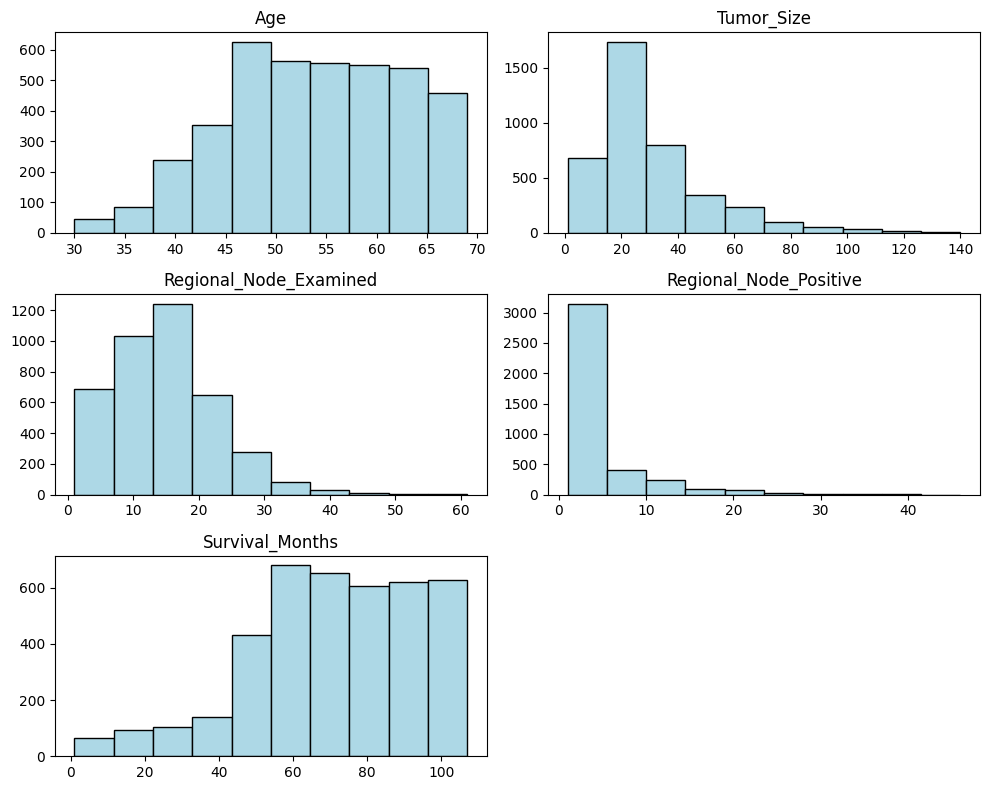

In [14]:
#all histograms as one picture
plt.figure(figsize=(10, 8))
df.hist(figsize=(10, 8), color='lightblue', edgecolor='black', grid=False)
plt.tight_layout()
plt.show()

In [15]:
#all histograms separately
pretty_hist('Age')
pretty_hist('Tumor_Size')
pretty_hist('Regional_Node_Examined')
pretty_hist('Regional_Node_Positive')
pretty_hist('Survival_Months')

In [16]:
#bar plots of all object columns
df_object_columns = df.select_dtypes(include=['object'])
for col_name in df_object_columns.columns:
    pretty_bar(col_name)

In [17]:
#use pretty box plot function
pretty_box('Age')
pretty_box('Tumor_Size')
pretty_box('Regional_Node_Examined')
pretty_box('Regional_Node_Positive')
pretty_box('Survival_Months')

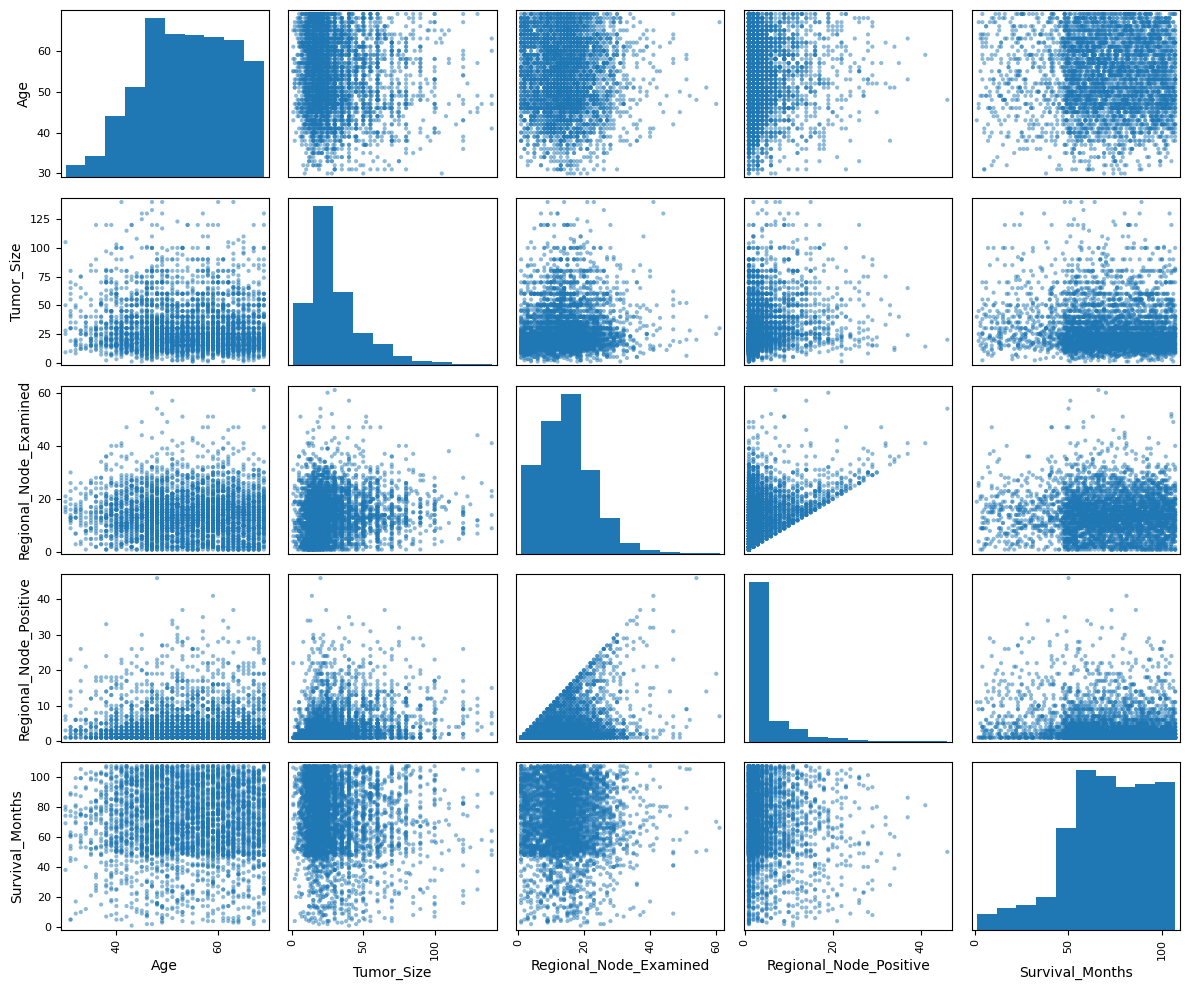

In [18]:
#check if there are any correlations
pd.plotting.scatter_matrix(df, figsize=(12, 10))
plt.tight_layout()
plt.savefig('scatter_matrix.png')

Data Balance Analysis? -> will be done in the report from the visualized data above

In [19]:
df_columns = df.columns
for s in range(len(df_columns)):
    column_name= df_columns[s]
    print(df[column_name].value_counts())

Age
46    163
49    162
47    161
53    155
55    154
63    153
62    149
51    148
59    147
50    144
57    144
61    143
60    140
48    140
56    132
54    128
65    122
58    120
67    119
66    119
52    118
64    116
68    111
69    108
45    102
43     92
42     82
44     79
40     72
41     71
39     52
38     45
37     28
36     24
35     20
33     15
31     14
34     14
32     13
30      5
Name: count, dtype: int64
Race
White    3413
Other     320
Black     291
Name: count, dtype: int64
Marital_Status
Married      2643
Single        615
Divorced      486
Widowed       235
Separated      45
Name: count, dtype: int64
T_Stage
T2    1786
T1    1603
T3     533
T4     102
Name: count, dtype: int64
N_Stage
N1    2732
N2     820
N3     472
Name: count, dtype: int64
6th_Stage
IIA     1305
IIB     1130
IIIA    1050
IIIC     472
IIIB      67
Name: count, dtype: int64
differentiate
Moderately differentiated    2351
Poorly differentiated        1111
Well differentiated           543
Undi

Outlier Analysis

In [20]:
RNE_outliers = find_outliers(df, 'Regional_Node_Examined')
print(len(RNE_outliers))
print(RNE_outliers.head(10))

135
     Age   Race Marital_Status T_Stage N_Stage 6th_Stage  \
25    63  White        Married      T2      N3      IIIC   
57    50  White        Married      T1      N1       IIA   
100   38  White        Single       T3      N3      IIIC   
112   46  White        Single       T2      N3      IIIC   
178   52  White        Married      T2      N3      IIIC   
180   60  White        Married      T1      N1       IIA   
188   62  White        Married      T2      N2      IIIA   
227   55  White       Divorced      T3      N1      IIIA   
264   67  White        Widowed      T1      N1       IIA   
266   65  White        Married      T1      N1       IIA   

                 differentiate Grade   A_Stage  Tumor_Size Estrogen_Status  \
25   Moderately differentiated     2  Regional          22        Positive   
57   Moderately differentiated     2  Regional          18        Positive   
100  Moderately differentiated     2  Regional          70        Positive   
112  Moderately differe

In [21]:
RNP_outliers = find_outliers(df, 'Regional_Node_Positive')
print(len(RNP_outliers))
print(RNP_outliers.head(10))

220
     Age   Race Marital_Status T_Stage N_Stage 6th_Stage  \
8     40  White       Divorced      T4      N3      IIIC   
24    62  White        Married      T1      N3      IIIC   
25    63  White        Married      T2      N3      IIIC   
26    48  White        Married      T2      N3      IIIC   
66    31  White        Married      T3      N3      IIIC   
71    64  White        Married      T2      N3      IIIC   
74    67  White        Married      T2      N3      IIIC   
93    45  Other        Married      T2      N3      IIIC   
100   38  White        Single       T3      N3      IIIC   
122   50  White        Single       T2      N3      IIIC   

                 differentiate Grade   A_Stage  Tumor_Size Estrogen_Status  \
8        Poorly differentiated     3  Regional         103        Positive   
24       Poorly differentiated     3  Regional          20        Positive   
25   Moderately differentiated     2  Regional          22        Positive   
26       Poorly differe

In [22]:
survival_outliers = find_outliers(df, 'Survival_Months')
print(len(survival_outliers))
print(survival_outliers.head(10))

197
     Age   Race Marital_Status T_Stage N_Stage 6th_Stage  \
7     40  White        Married      T2      N1       IIB   
71    64  White        Married      T2      N3      IIIC   
96    50  White       Divorced      T2      N1       IIB   
102   39  White        Married      T2      N1       IIB   
106   54  White        Married      T2      N1       IIB   
125   62  White        Married      T1      N1       IIA   
159   55  White        Married      T2      N3      IIIC   
160   59  White        Married      T2      N2      IIIA   
182   63  White       Divorced      T1      N1       IIA   
203   50  White        Single       T2      N3      IIIC   

                 differentiate Grade   A_Stage  Tumor_Size Estrogen_Status  \
7    Moderately differentiated     2  Regional          30        Positive   
71       Poorly differentiated     3  Regional          34        Positive   
96   Moderately differentiated     2  Regional          30        Positive   
102  Moderately differe

In [23]:
tumor_outliers = find_outliers(df, 'Tumor_Size')
print(len(tumor_outliers))
print(tumor_outliers.head(10))

217
     Age   Race Marital_Status T_Stage N_Stage 6th_Stage  \
8     40  White       Divorced      T4      N3      IIIC   
52    60  Black        Married      T3      N1      IIIA   
53    63  White        Married      T3      N1      IIIA   
63    59  White        Married      T3      N1      IIIA   
70    49  White        Married      T3      N2      IIIA   
86    48  White        Married      T3      N2      IIIA   
87    52  White        Married      T3      N1      IIIA   
116   50  White        Married      T3      N1      IIIA   
155   69  White        Widowed      T3      N2      IIIA   
184   51  Black        Married      T3      N3      IIIC   

                 differentiate Grade   A_Stage  Tumor_Size Estrogen_Status  \
8        Poorly differentiated     3  Regional         103        Positive   
52       Poorly differentiated     3  Regional         120        Positive   
53         Well differentiated     1  Regional          77        Positive   
63   Moderately differe

In [24]:
#check if outliers from the different categories are the same or at least some of them
#drop z_score column
df_overlap_outliers = pd.concat([RNE_outliers, RNP_outliers, survival_outliers, tumor_outliers])
df_overlap_outliers.drop(columns=['z_score'], inplace=True)
duplicate_rows = df_overlap_outliers[df_overlap_outliers.duplicated()]

duplicate_rows

Age   Race Marital_Status T_Stage N_Stage 6th_Stage  \
25     63  White        Married      T2      N3      IIIC   
100    38  White        Single       T3      N3      IIIC   
289    41  White        Married      T3      N3      IIIC   
530    53  White        Married      T1      N3      IIIC   
544    52  White       Divorced      T1      N3      IIIC   
...   ...    ...            ...     ...     ...       ...   
3591   58  White       Divorced      T4      N2      IIIB   
3594   60  White       Divorced      T3      N2      IIIA   
3620   47  White        Married      T3      N3      IIIC   
3734   36  White       Divorced      T3      N3      IIIC   
3893   52  White        Married      T3      N3      IIIC   

                  differentiate Grade   A_Stage  Tumor_Size Estrogen_Status  \
25    Moderately differentiated     2  Regional          22        Positive   
100   Moderately differentiated     2  Regional          70        Positive   
289       Poorly differentiated     3  Regional         140        Positive   
530         Well differentiated     1  Regional           8        Positive   
544   Moderately differentiated     2  Regional          15        Positive   
...                         ...   ...       ...         ...             ...   
3591      Poorly differentiated     3   Distant         120        Negative   
3594      Poorly differentiated     3  Regional          90        Negative   
3620  Moderately differentiated     2   Distant          82        Positive   
3734      Poorly differentiated     3  Regional         120        Negative   
3893  Moderately differentiated     2  Regional          75        Positive   

     Progesterone_Status  Regional_Node_Examined  Regional_Node_Positive  \
25              Positive                      31                      17   
100             Positive                      33                      24   
289             Positive                      41                      15   
530             Positive                      38                      28   
544             Positive                      33                      29   
...                  ...                     ...                     ...   
3591            Negative                       8                       5   
3594            Negative                      12                       4   
3620            Negative                      31                      14   
3734            Negative                      15                      14   
3893            Positive                      40                      32   

      Survival_Months Status  
25                 70  Alive  
100                54   Dead  
289                51   Dead  
530                10  Alive  
544                93  Alive  
...               ...    ...  
3591               21   Dead  
3594               12   Dead  
3620              107  Alive  
3734               24   Dead  
3893               73  Alive  

[115 rows x 16 columns]

In [25]:
df_outliers_no_dups = df_overlap_outliers.drop_duplicates()
df_outliers_no_dups

Age   Race Marital_Status T_Stage N_Stage 6th_Stage  \
25     63  White        Married      T2      N3      IIIC   
57     50  White        Married      T1      N1       IIA   
100    38  White        Single       T3      N3      IIIC   
112    46  White        Single       T2      N3      IIIC   
178    52  White        Married      T2      N3      IIIC   
...   ...    ...            ...     ...     ...       ...   
3930   38  Black        Single       T3      N3      IIIC   
3965   47  White        Married      T3      N2      IIIA   
3991   51  White        Married      T3      N3      IIIC   
4009   53  White       Divorced      T3      N1      IIIA   
4012   51  White        Married      T3      N3      IIIC   

                  differentiate Grade   A_Stage  Tumor_Size Estrogen_Status  \
25    Moderately differentiated     2  Regional          22        Positive   
57    Moderately differentiated     2  Regional          18        Positive   
100   Moderately differentiated     2  Regional          70        Positive   
112   Moderately differentiated     2  Regional          50        Positive   
178   Moderately differentiated     2  Regional          25        Positive   
...                         ...   ...       ...         ...             ...   
3930  Moderately differentiated     2   Distant         120        Positive   
3965        Well differentiated     1  Regional         140        Positive   
3991      Poorly differentiated     3  Regional          90        Positive   
4009  Moderately differentiated     2  Regional         100        Positive   
4012      Poorly differentiated     3  Regional          80        Positive   

     Progesterone_Status  Regional_Node_Examined  Regional_Node_Positive  \
25              Positive                      31                      17   
57              Negative                      49                       1   
100             Positive                      33                      24   
112             Positive                      34                      10   
178             Positive                      31                      14   
...                  ...                     ...                     ...   
3930            Positive                      14                      11   
3965            Positive                      23                       7   
3991            Positive                      13                      10   
4009            Negative                      20                       1   
4012            Positive                      20                      12   

      Survival_Months Status  
25                 70  Alive  
57                106  Alive  
100                54   Dead  
112                74  Alive  
178                55  Alive  
...               ...    ...  
3930               50  Alive  
3965               64  Alive  
3991               88  Alive  
4009              107  Alive  
4012               79  Alive  

[654 rows x 16 columns]

In [26]:
#surival months that have only one occurance -> possible outliers?
counts_by_status = df.groupby("Status")["Survival_Months"].value_counts()
counts_equal_to_1 = counts_by_status[counts_by_status == 1]
counts_equal_to_1

Status  Survival_Months
Alive   1                  1
        2                  1
        4                  1
        7                  1
        11                 1
        13                 1
        17                 1
        21                 1
        26                 1
        28                 1
        30                 1
        43                 1
Dead    85                 1
        92                 1
        94                 1
        98                 1
        99                 1
        101                1
        102                1
Name: count, dtype: int64

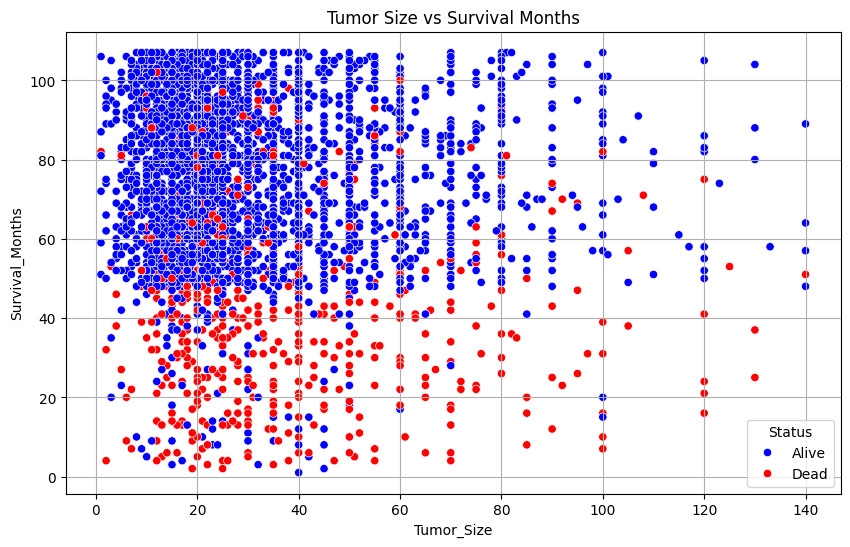

In [27]:
possible_connection(df)

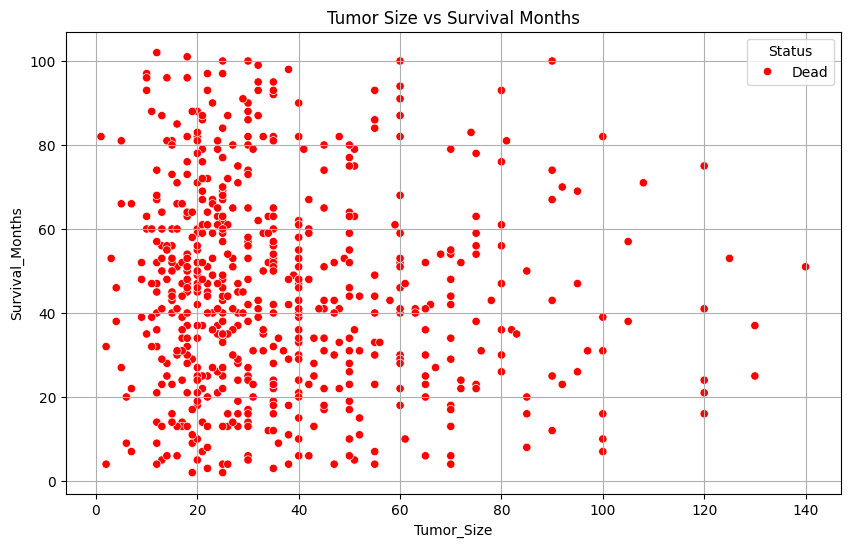

In [28]:
df_dead = df[df['Status'] == 'Dead']
possible_connection(df_dead)

Data Quality Analysis  -> will be done in the report based on missing values, visualizations, data relationships, consistency

## Feature Engineering

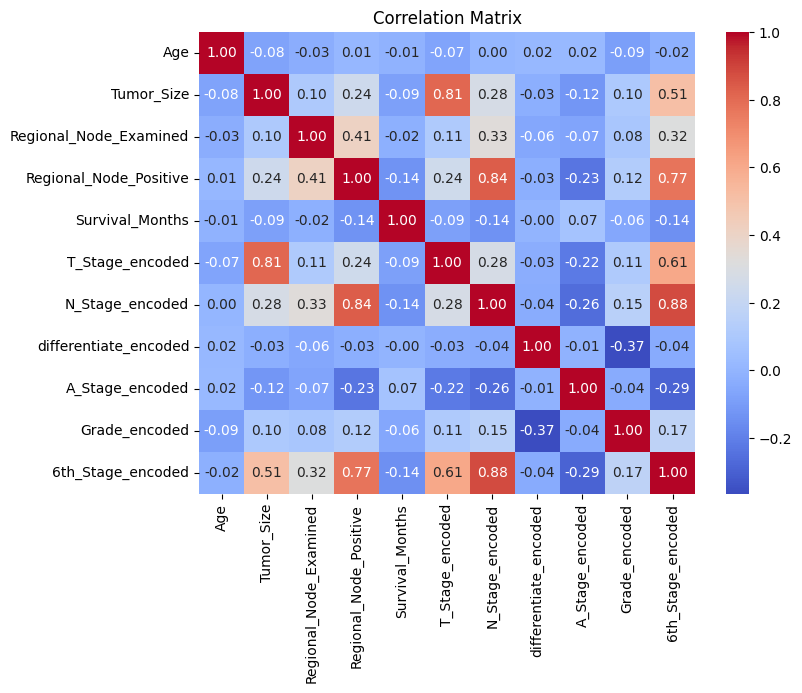

In [91]:

df.drop(columns=['z_score'], inplace=True)
numerical_columns = df.select_dtypes(include=['float64', 'int64'])
correlation_matrix = numerical_columns.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot= True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.savefig('Correlation_Matrix.png')
plt.show()


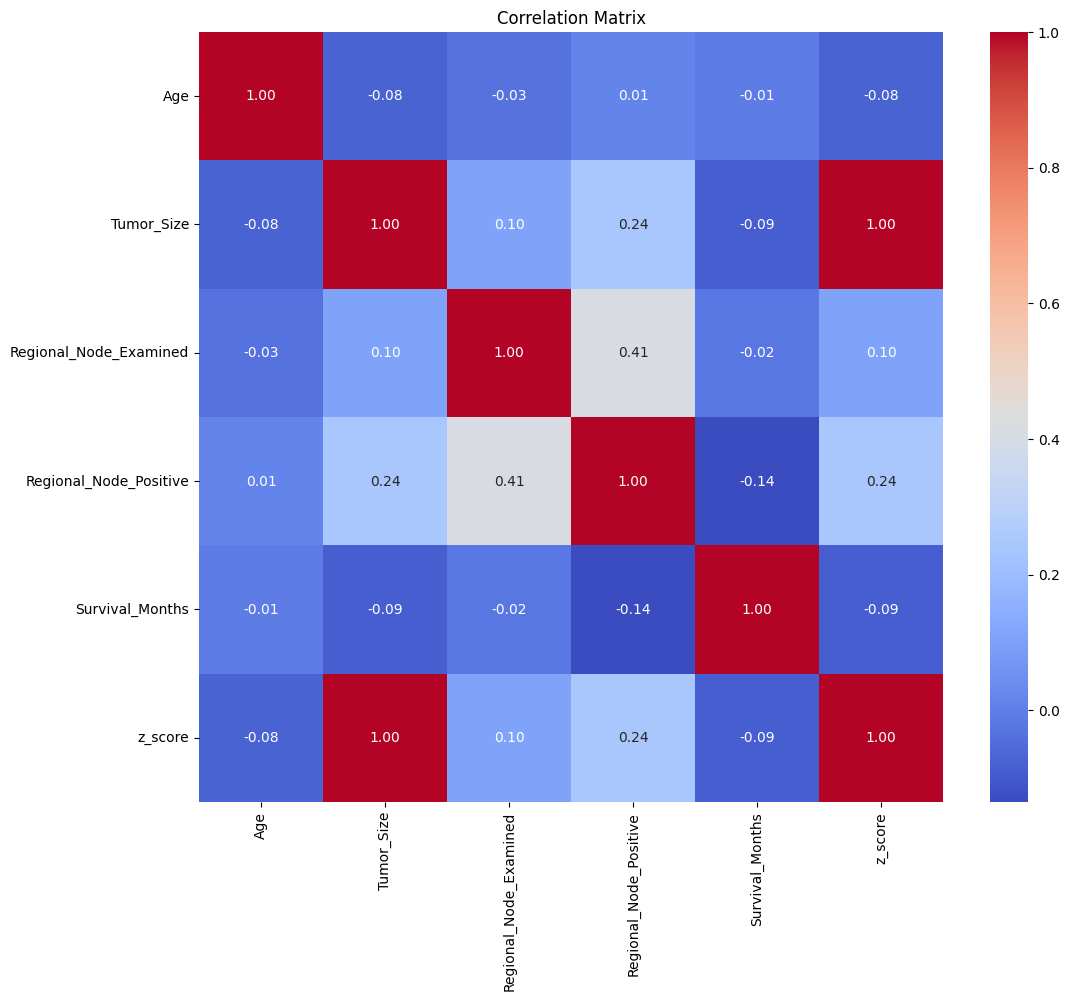

In [30]:
numerical_columns = df.select_dtypes(include=['float64', 'int64'])
correlation_matrix = numerical_columns.corr()

# Create a heatmap of the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()


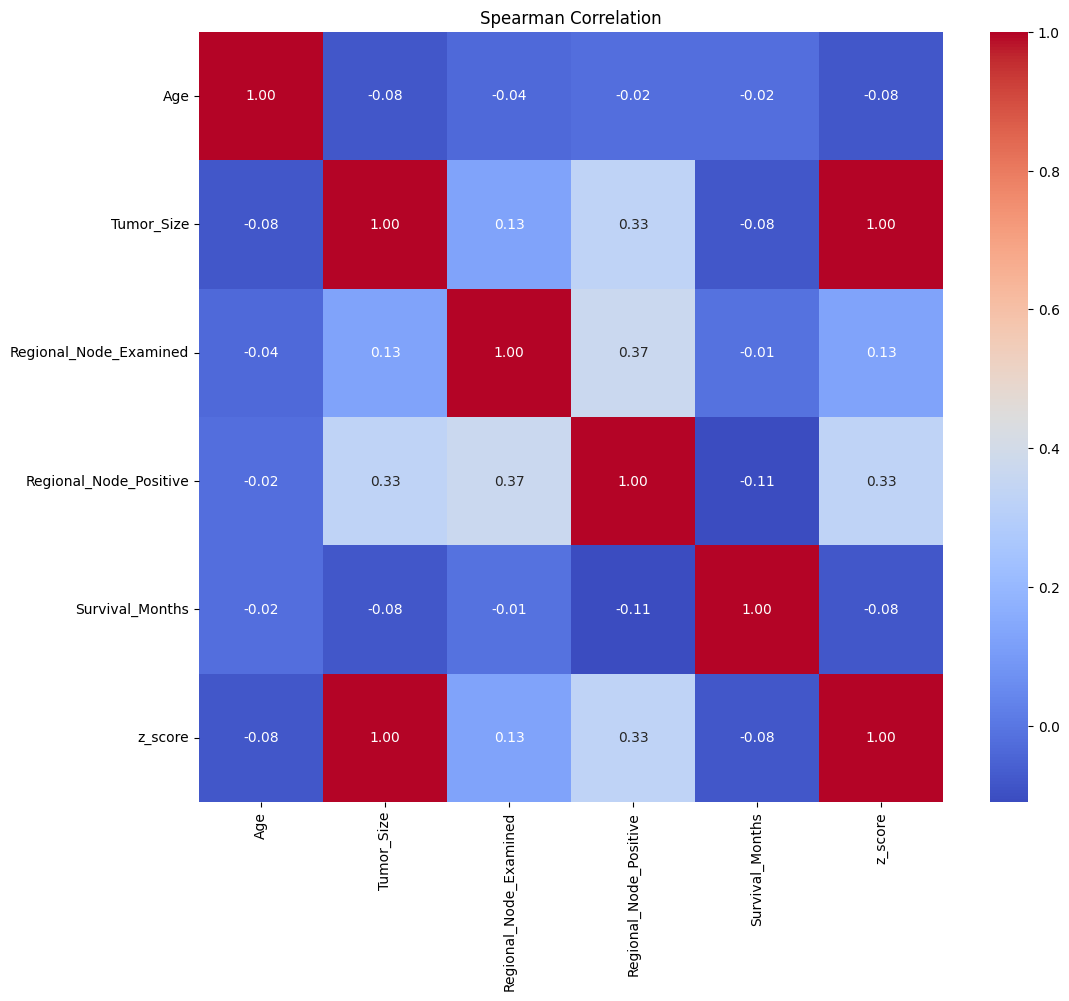

In [31]:
spearman_corr = numerical_columns.corr(method='spearman')
spearman_corr

plt.figure(figsize=(12, 10))
sns.heatmap(spearman_corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Spearman Correlation')
plt.show()

In [32]:
#encoding
pd.reset_option('display.max_columns')
pd.reset_option('display.max_rows')
label_encoder = LabelEncoder()
df['T_Stage_encoded'] = label_encoder.fit_transform(df['T_Stage'])
df['N_Stage_encoded'] = label_encoder.fit_transform(df['N_Stage'])
df['differentiate_encoded'] = label_encoder.fit_transform(df['differentiate'])
df['A_Stage_encoded'] = label_encoder.fit_transform(df['A_Stage'])
df['Grade_encoded'] = label_encoder.fit_transform(df['Grade'])
df['6th_Stage_encoded'] = label_encoder.fit_transform(df['6th_Stage'])

one_hot_encoded_df = pd.get_dummies(df, columns=['Race', 'Marital_Status', 'Estrogen_Status', 'Progesterone_Status', 'Status'])
one_hot_encoded_df[['Race_Black', 'Race_Other',
       'Race_White', 'Marital_Status_Divorced', 'Marital_Status_Married',
       'Marital_Status_Separated', 'Marital_Status_Single ',
       'Marital_Status_Widowed', 'Estrogen_Status_Negative',
       'Estrogen_Status_Positive', 'Progesterone_Status_Negative',
       'Progesterone_Status_Positive', 'Status_Alive', 'Status_Dead']] = one_hot_encoded_df[['Race_Black', 'Race_Other',
       'Race_White', 'Marital_Status_Divorced', 'Marital_Status_Married',
       'Marital_Status_Separated', 'Marital_Status_Single ',
       'Marital_Status_Widowed', 'Estrogen_Status_Negative',
       'Estrogen_Status_Positive', 'Progesterone_Status_Negative',
       'Progesterone_Status_Positive', 'Status_Alive', 'Status_Dead']].astype(int)
ml_ready_df = one_hot_encoded_df[['Age',
    'Tumor_Size', 'Regional_Node_Examined',
       'Regional_Node_Positive', 'T_Stage_encoded',
       'N_Stage_encoded', 'differentiate_encoded', 'A_Stage_encoded',
       'Grade_encoded', '6th_Stage_encoded', 'Race_Black', 'Race_Other',
       'Race_White', 'Marital_Status_Divorced', 'Marital_Status_Married',
       'Marital_Status_Separated', 'Marital_Status_Single ',
       'Marital_Status_Widowed',
       'Estrogen_Status_Positive',
       'Progesterone_Status_Positive', 'Status_Alive']].copy()
ml_ready_df

Age  Tumor_Size  Regional_Node_Examined  Regional_Node_Positive  \
0      68           4                      24                       1   
1      50          35                      14                       5   
2      58          63                      14                       7   
3      58          18                       2                       1   
4      47          41                       3                       1   
...   ...         ...                     ...                     ...   
4019   62           9                       1                       1   
4020   56          46                      14                       8   
4021   68          22                      11                       3   
4022   58          44                      11                       1   
4023   46          30                       7                       2   

      T_Stage_encoded  N_Stage_encoded  differentiate_encoded  \
0                   0                0                      1   
1                   1                1                      0   
2                   2                2                      0   
3                   0                0                      1   
4                   1                0                      1   
...               ...              ...                    ...   
4019                0                0                      0   
4020                1                1                      0   
4021                1                0                      0   
4022                1                0                      0   
4023                1                0                      0   

      A_Stage_encoded  Grade_encoded  6th_Stage_encoded  ...  Race_Other  \
0                   1              3                  0  ...           0   
1                   1              2                  2  ...           0   
2                   1              2                  4  ...           0   
3                   1              3                  0  ...           0   
4                   1              3                  1  ...           0   
...               ...            ...                ...  ...         ...   
4019                1              2                  0  ...           1   
4020                1              2                  2  ...           0   
4021                1              2                  1  ...           0   
4022                1              2                  1  ...           0   
4023                1              2                  1  ...           0   

      Race_White  Marital_Status_Divorced  Marital_Status_Married  \
0              1                        0                       1   
1              1                        0                       1   
2              1                        1                       0   
3              1                        0                       1   
4              1                        0                       1   
...          ...                      ...                     ...   
4019           0                        0                       1   
4020           1                        1                       0   
4021           1                        0                       1   
4022           0                        1                       0   
4023           1                        0                       1   

      Marital_Status_Separated  Marital_Status_Single   \
0                            0                       0   
1                            0                       0   
2                            0                       0   
3                            0                       0   
4                            0                       0   
...                        ...                     ...   
4019                         0                       0   
4020                         0                       0   
4021                         0                       0   
4022                      

In [33]:
X = ml_ready_df.drop(columns=['Status_Alive'])
y = ml_ready_df['Status_Alive']

print(len(X), len(y))
X.columns
y

4024 4024


0       1
1       1
2       1
3       1
4       1
       ..
4019    1
4020    1
4021    1
4022    1
4023    1
Name: Status_Alive, Length: 4024, dtype: int64

In [34]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X, y)
rf_importances = rf_model.feature_importances_
feature_names = X.columns
rf_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': rf_importances})
rf_importance_df = rf_importance_df.sort_values(by='Importance', ascending=False)
print("Random Forest Feature Importance:")
print(rf_importance_df)

Random Forest Feature Importance:
                         Feature  Importance
2         Regional_Node_Examined    0.187495
0                            Age    0.185584
1                     Tumor_Size    0.175009
3         Regional_Node_Positive    0.123096
9              6th_Stage_encoded    0.034117
4                T_Stage_encoded    0.033313
5                N_Stage_encoded    0.031372
8                  Grade_encoded    0.030421
19  Progesterone_Status_Positive    0.029589
18      Estrogen_Status_Positive    0.025026
6          differentiate_encoded    0.024143
14        Marital_Status_Married    0.021835
16        Marital_Status_Single     0.017222
13       Marital_Status_Divorced    0.016380
12                    Race_White    0.015268
10                    Race_Black    0.014757
11                    Race_Other    0.011497
17        Marital_Status_Widowed    0.010224
7                A_Stage_encoded    0.007182
15      Marital_Status_Separated    0.006472


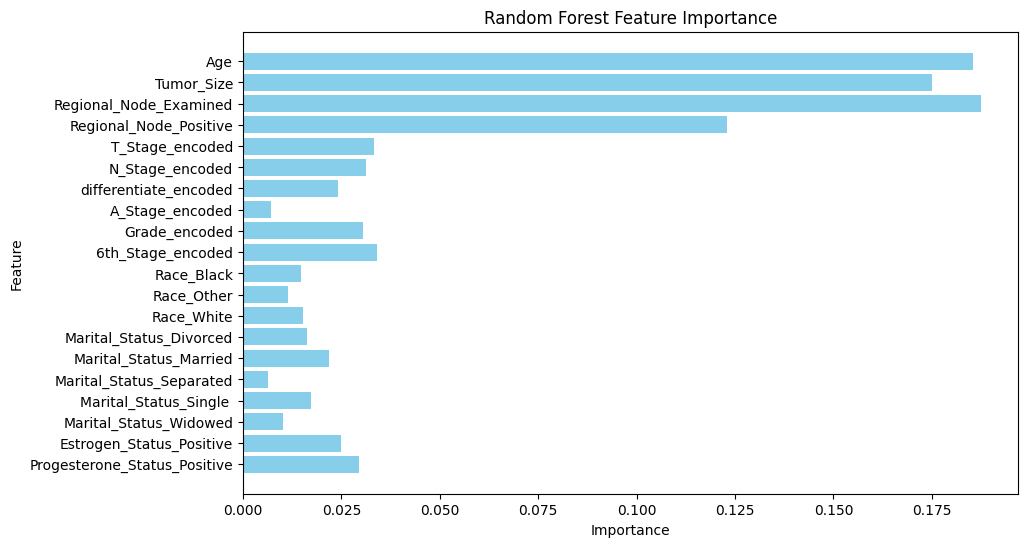

In [35]:
plt.figure(figsize=(10, 6))
plt.barh(feature_names, rf_importances, color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Random Forest Feature Importance')
plt.gca().invert_yaxis()
plt.savefig('Feature_Importance.png')
plt.show()

In [36]:
boolean_numerical_columns = []
for col in X.columns:
    if col in numerical_columns:
        boolean_numerical_columns.append(True)
    else:
        boolean_numerical_columns.append(False)

In [37]:
X_numerical = X.loc[:, boolean_numerical_columns]
X_numerical

Age  Tumor_Size  Regional_Node_Examined  Regional_Node_Positive
0      68           4                      24                       1
1      50          35                      14                       5
2      58          63                      14                       7
3      58          18                       2                       1
4      47          41                       3                       1
...   ...         ...                     ...                     ...
4019   62           9                       1                       1
4020   56          46                      14                       8
4021   68          22                      11                       3
4022   58          44                      11                       1
4023   46          30                       7                       2

[4024 rows x 4 columns]

In [38]:
scaler = MinMaxScaler()
X_numerical_scaled = scaler.fit_transform(X_numerical)
X_scaled = X.copy()
X_scaled.loc[:, boolean_numerical_columns]  = X_numerical_scaled
X_scaled

/var/folders/l4/g438h7v9007346ppbyxys7l40000gq/T/ipykernel_39410/1672254271.py:4: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.97435897 0.51282051 0.71794872 ... 0.97435897 0.71794872 0.41025641]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

/var/folders/l4/g438h7v9007346ppbyxys7l40000gq/T/ipykernel_39410/1672254271.py:4: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.02158273 0.24460432 0.44604317 ... 0.15107914 0.30935252 0.20863309]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

/var/folders/l4/g438h7v9007346ppbyxys7l40000gq/T/ipykernel_39410/1672254271.py:4: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.38333333 0.21666667 0.21666667 ... 0.16666667 0.16666667 0.1       ]' ha

Age  Tumor_Size  Regional_Node_Examined  Regional_Node_Positive  \
0     0.974359    0.021583                0.383333                0.000000   
1     0.512821    0.244604                0.216667                0.088889   
2     0.717949    0.446043                0.216667                0.133333   
3     0.717949    0.122302                0.016667                0.000000   
4     0.435897    0.287770                0.033333                0.000000   
...        ...         ...                     ...                     ...   
4019  0.820513    0.057554                0.000000                0.000000   
4020  0.666667    0.323741                0.216667                0.155556   
4021  0.974359    0.151079                0.166667                0.044444   
4022  0.717949    0.309353                0.166667                0.000000   
4023  0.410256    0.208633                0.100000                0.022222   

      T_Stage_encoded  N_Stage_encoded  differentiate_encoded  \
0                   0                0                      1   
1                   1                1                      0   
2                   2                2                      0   
3                   0                0                      1   
4                   1                0                      1   
...               ...              ...                    ...   
4019                0                0                      0   
4020                1                1                      0   
4021                1                0                      0   
4022                1                0                      0   
4023                1                0                      0   

      A_Stage_encoded  Grade_encoded  6th_Stage_encoded  Race_Black  \
0                   1              3                  0           0   
1                   1              2                  2           0   
2                   1              2                  4           0   
3                   1              3                  0           0   
4                   1              3                  1           0   
...               ...            ...                ...         ...   
4019                1              2                  0           0   
4020                1              2                  2           0   
4021                1              2                  1           0   
4022                1              2                  1           1   
4023                1              2                  1           0   

      Race_Other  Race_White  Marital_Status_Divorced  Marital_Status_Married  \
0              0           1                        0                       1   
1              0           1                        0                       1   
2              0           1                        1                       0   
3              0           1                        0                       1   
4              0           1                        0                       1   
...          ...         ...                      ...                     ...   
4019           1           0                        0                       1   
4020           0           1                        1                       0   
4021           0           1                        0                       1   
4022           0           0                        1                       0   
4023           0           1                        0                       1   

      Marital_Status_Separated  Marital_Status_Single   \
0                            0                       0   
1                            0                       0   
2                            0                       0   
3                            0                       0   
4                            0                       0   
...                        ...                     ...   
4019                         0                       0   
402

In [39]:
y.value_counts()

Status_Alive
1    3408
0     616
Name: count, dtype: int64

## Data Set Split

In [40]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=1)
#60 20 20 split

In [41]:
y_train.value_counts()

Status_Alive
1    2036
0     378
Name: count, dtype: int64

In [42]:
y_val.value_counts()

Status_Alive
1    673
0    132
Name: count, dtype: int64

In [43]:
y_test.value_counts()

Status_Alive
1    699
0    106
Name: count, dtype: int64

## ML Training and Hyperparameter Tuning
Training w/o Hyperparameter Tuning

In [44]:
#Logistsic Regression
model = LogisticRegression(max_iter=500)
model.fit(X_train, y_train)

LogisticRegression(max_iter=500)

In [45]:
log_reg_y_pred = model.predict(X_val)

In [92]:
log_reg_accuracy, log_reg_precision, log_reg_recall, log_reg_f1, log_reg_auc = evaluation_metrics(y_val, log_reg_y_pred, 'macro')

macro
Accuracy: 0.853416149068323
Precision: 0.7688725490196079
Recall: 0.5926144806159664
F1-Score: 0.6159475369537795
Roc_Auc: 0.5926144806159666


In [47]:
#Support Vector Machine
clf = svm.SVC(kernel='linear')
clf.fit(X_train, y_train)

SVC(kernel='linear')

In [48]:
svm_y_pred = clf.predict(X_val)

In [93]:
svm_y_accuracy, svm_y_precision, svm_y_recall, svm_y_f1, svm_y_auc = evaluation_metrics(y_val, svm_y_pred, 'macro')

macro
Accuracy: 0.8111801242236025
Precision: 0.6556576162816876
Recall: 0.6556576162816876
F1-Score: 0.6556576162816876
Roc_Auc: 0.6556576162816876


In [50]:
#Gaussian Naive Bayes -> doesnt have any hyperparameters
gnb = GaussianNB()
gnb.fit(X_train, y_train)

GaussianNB()

In [51]:
gnb_y_pred = gnb.predict(X_val)

In [94]:
gnb_y_accuracy, gnb_y_precision, gnb_y_recall, gnb_y_f1, gnb_y_auc = evaluation_metrics(y_val, gnb_y_pred, 'macro')

macro
Accuracy: 0.8024844720496894
Precision: 0.6553088385625541
Recall: 0.6778614525642758
F1-Score: 0.664731814264647
Roc_Auc: 0.6778614525642758


In [53]:
#gradient boosting machines
lgb_train = lgb.Dataset(X_train, y_train)
lgb_val = lgb.Dataset(X_val, y_val, reference=lgb_train)

params = {
    'objective': 'binary',
    'metric': 'auc',
    'num_leaves': 31,
    'learning_rate': 0.1,
    'feature_fraction': 0.9,
    'is_unbalance': 'true'
    #'class_weight' : 'balanced'
}


gbm = lgb.train(params, lgb_train, num_boost_round=100, valid_sets=lgb_val)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2036, number of negative: 378
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001447 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 241
[LightGBM] [Info] Number of data points in the train set: 2414, number of used features: 20
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.843413 -> initscore=1.683848
[LightGBM] [Info] Start training from score 1.683848


In [95]:
gbm_y_pred = gbm.predict(X_val, num_iteration=gbm.best_iteration)
#print(gbm_y_pred)
gbm_y_pred_class = (gbm_y_pred > 0.5).astype(int)
gbm_accuracy = (gbm_y_pred_class == y_val).mean()
#print("Accuracy:", gbm_accuracy)
gbm_accuracy, gbm_precision, gbm_recall, gbm_f1, gbm_auc = evaluation_metrics(y_val, gbm_y_pred_class, None)

gbm_avg_precision = np.mean(np.array(gbm_precision))
gbm_avg_recall = np.mean(np.array(gbm_recall))
gbm_avg_f1 = np.mean(np.array(gbm_f1))

print("Average Precision:", gbm_avg_precision)
print("Average Recall:", gbm_avg_recall)
print(gbm_avg_f1)
gbm_f1_actually = f1_for_lightgbm(y_val, gbm_y_pred, 'macro')


None
Accuracy: 0.7739130434782608
Precision: [0.35795455 0.89030207]
Recall: [0.47727273 0.8320951 ]
F1-Score: [0.40909091 0.86021505]
Roc_Auc: 0.6546839119275969
Average Precision: 0.6241283061136003
Average Recall: 0.6546839119275969
0.634652981427175
F1-score for Lightgbm: 0.634652981427175


In [55]:
#Decision Tree
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

DecisionTreeClassifier()

In [96]:
dt_y_pred = clf.predict(X_val)
dt_accuracy, dt_precision, dt_recall, dt_f1, dt_auc = evaluation_metrics(y_val, dt_y_pred, 'macro')

macro
Accuracy: 0.7577639751552795
Precision: 0.5639287119192272
Recall: 0.5658573100995092
F1-Score: 0.5648395332784445
Roc_Auc: 0.5658573100995092


In [97]:
#dummy classifier for comparison
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)

dummy_y_pred = dummy_clf.predict(X_val)
dummy_accuracy, dummy_precision, dummy_recall, dummy_f1, dummy_auc = evaluation_metrics(y_val, dummy_y_pred, 'macro')

macro
Accuracy: 0.8360248447204969
Precision: 0.41801242236024844
Recall: 0.5
F1-Score: 0.4553450608930988
Roc_Auc: 0.5


/usr/local/Caskroom/miniconda/base/envs/explore/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [98]:
#gradient boost classifier
clf_gbm = GradientBoostingClassifier(loss='log_loss')
clf_gbm.fit(X_train, y_train)
clf_gbm_y_pred = clf_gbm.predict(X_val)
gbm_acc, gmb_pre, gbm_rec, gbm_f1_sklearn, gbm_roc_auc = evaluation_metrics(y_val, clf_gbm_y_pred, 'macro')

macro
Accuracy: 0.8322981366459627
Precision: 0.661483186436872
Recall: 0.5647597820703318
F1-Score: 0.5757352166122062
Roc_Auc: 0.5647597820703318


with Hyperparameter Tuning

In [59]:
#Logistic Regression
numbers_for_C = []
for i in range(20):
    value = 1 + i * 0.5
    numbers_for_C.append(value)

numbers_for_C.append(25)
numbers_for_C.append(50)
numbers_for_C.append(75)
numbers_for_C.append(100)

numbers_for_max_iter = []
for i in range(100, 201, 5):
    numbers_for_max_iter.append(i)

numbers_for_max_iter.append(500)
numbers_for_max_iter.append(1000)
numbers_for_max_iter.append(10000)

In [88]:
lg_model = LogisticRegression()
lg_param_grid = {
    'penalty': ['l1', 'l2'],
    'C': numbers_for_C,
    'class_weight': [None, 'balanced'],
    'solver': ['liblinear', 'lbfgs', 'newton-cg', 'sag', 'saga'],
    'max_iter': numbers_for_max_iter,
    'fit_intercept': [True, False],
    'random_state': [42]
}

lg_best_params, lg_best_model, lg_y_pred = grid_search(lg_model, lg_param_grid, X_train, y_train, X_val, 'roc_auc')

/usr/local/Caskroom/miniconda/base/envs/explore/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/usr/local/Caskroom/miniconda/base/envs/explore/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/usr/local/Caskroom/miniconda/base/envs/explore/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/usr/local/Caskroom/miniconda/base/envs/explore/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/usr/local/Caskroom/miniconda/base/envs/explore/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/usr/local/Cask

In [99]:
lg_accuracy, lg_precision, lg_recall, lg_f1, lg_auc = evaluation_metrics(y_val, lg_y_pred, 'macro')
lg_best_model

macro
Accuracy: 0.7354037267080745
Precision: 0.6338108519269777
Recall: 0.7138660002701607
F1-Score: 0.6414973624291995
Roc_Auc: 0.7138660002701609


LogisticRegression(C=1.5, class_weight='balanced', fit_intercept=False,
                   penalty='l1', random_state=42, solver='saga')

In [100]:
#two differently tuned ones to show?
better_model = LogisticRegression(C=5, max_iter=525, penalty='l1', random_state=42, solver='saga', class_weight='balanced')
better_model.fit(X_train, y_train)
better_y_pred = better_model.predict(X_val)
#max_iter 125 -> but model doesnt converge
lg_better_accuracy, lg_better_precision, lg_better_recall, lg_better_f1, lg_better_auc = evaluation_metrics(y_val, better_y_pred, 'macro')


macro
Accuracy: 0.7366459627329193
Precision: 0.6359108993013088
Recall: 0.7176538790580396
F1-Score: 0.6437934143734972
Roc_Auc: 0.7176538790580396


In [104]:
#run again
balanced_lg_model = LogisticRegression()
balanced_lg_param_grid = {
    'penalty': ['l1', 'l2'],
    'C': numbers_for_C,
    'class_weight': ['balanced'],
    'solver': ['liblinear', 'lbfgs', 'newton-cg', 'sag', 'saga'],
    'max_iter': numbers_for_max_iter,
    'fit_intercept': [True, False],
    'random_state': [42]
}

balanced_lg_best_params, balanced_lg_best_model, balanced_lg_y_pred = grid_search(balanced_lg_model, balanced_lg_param_grid, X_train, y_train, X_val, 'roc_auc')
balanced_lg_accuracy, balanced_lg_precision, balanced_lg_recall, balanced_lg_f1, balanced_lg_auc = evaluation_metrics(y_val, balanced_lg_y_pred, 'macro')
balanced_lg_best_model

/usr/local/Caskroom/miniconda/base/envs/explore/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/usr/local/Caskroom/miniconda/base/envs/explore/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/usr/local/Caskroom/miniconda/base/envs/explore/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/usr/local/Caskroom/miniconda/base/envs/explore/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/usr/local/Caskroom/miniconda/base/envs/explore/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/usr/local/Cask

macro
Accuracy: 0.7354037267080745
Precision: 0.6338108519269777
Recall: 0.7138660002701607
F1-Score: 0.6414973624291995
Roc_Auc: 0.7138660002701609


/usr/local/Caskroom/miniconda/base/envs/explore/lib/python3.11/site-packages/sklearn/model_selection/_search.py:1051: UserWarning:

One or more of the test scores are non-finite: [0.74720848        nan        nan ... 0.74632252 0.74636775 0.7463676 ]



LogisticRegression(C=1.5, class_weight='balanced', fit_intercept=False,
                   penalty='l1', random_state=42, solver='saga')

In [64]:
#possibly change
balanced_best_lg_model = LogisticRegression(C=5, class_weight='balanced', penalty='l1', random_state=42, solver='liblinear')
balanced_best_lg_model.fit(X_train, y_train)
balanced_best_y_pred = balanced_best_lg_model.predict(X_val)
balanced_lg_better_accuracy, balanced_lg_better_precision, balanced_lg_better_recall, balanced_lg_better_f1 = evaluation_metrics(y_val, balanced_best_y_pred, 'macro')

macro
Accuracy: 0.7366459627329193
Precision: 0.6359108993013088
Recall: 0.7176538790580396
F1-Score: 0.6437934143734972


In [102]:
#Support Vector Machine
svm_C_numbers = np.concatenate([
    np.arange(0.1, 1.1, 0.4),
    np.arange(10, 101, 10),    
    np.arange(125, 301, 25)])

svm_model = svm.SVC()
svm_param_grid = {
    'C': svm_C_numbers,
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto'],
    'class_weight': [None, 'balanced']
}
svm_best_params, svm_best_model, svm_y_pred = grid_search(svm_model, svm_param_grid, X_train, y_train, X_val, 'roc_auc')
svm_accuracy, svm_precision, svm_recall, svm_f1, svm_auc = evaluation_metrics(y_val, svm_y_pred, 'macro')
svm_best_model

macro
Accuracy: 0.7590062111801242
Precision: 0.6434804736030655
Recall: 0.715802152280607
F1-Score: 0.6569984010682972
Roc_Auc: 0.715802152280607


SVC(C=225.0, class_weight='balanced', kernel='linear')

In [66]:
#gradient booster model?

In [109]:
#Decision Tree Classifier
dt_classifier = DecisionTreeClassifier()
dt_param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20],
    'min_samples_split': [2, 5, 7, 8, 9, 10, 11, 12, 15],
    'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8],
    'class_weight' : [None, 'balanced']
}
dt_best_params, dt_best_model, dt_y_pred = grid_search(dt_classifier, dt_param_grid, X_train, y_train, X_val, 'roc_auc')
dt_accuracy, dt_precision, dt_recall, dt_f1, dt_auc = evaluation_metrics(y_val, dt_y_pred, 'macro')
dt_best_model

macro
Accuracy: 0.8248447204968944
Precision: 0.6040979745642958
Recall: 0.5298527623936242
F1-Score: 0.5239383453916325
Roc_Auc: 0.5298527623936242


DecisionTreeClassifier(max_depth=5, min_samples_leaf=7, min_samples_split=11)

ML-Models with Test Data Set

In [ ]:
#Logistic Regression
test_y_pred = better_model.predict(X_test)
lg_test_accuracy, lg_test_precision, lg_test_recall, lg_test_f1, lg_test_auc = evaluation_metrics(y_test, test_y_pred, 'macro')

macro
Accuracy: 0.6770186335403726
Precision: 0.5551712988345775
Recall: 0.6059330040219181
F1-Score: 0.5420692431561996
AUC: 0.6059330040219181


In [106]:
lg_grid_model = LogisticRegression(C=1.5, class_weight='balanced', fit_intercept=False,
                   penalty='l1', random_state=42, solver='saga')
lg_grid_model.fit(X_train, y_train)
lg_grid_test_y = lg_grid_model.predict(X_test)
lg_grid_acc, lg_grid_pre, lg_grid_rec, lg_grid_f1, lg_grid_auc = evaluation_metrics(y_test, lg_grid_test_y, 'macro')

macro
Accuracy: 0.6782608695652174
Precision: 0.5556541582150102
Recall: 0.6066483116041785
F1-Score: 0.5429555373853799
Roc_Auc: 0.6066483116041784


In [110]:
#SVM
trained_svm_model = svm.SVC(C=225.0, class_weight='balanced', kernel='linear')
trained_svm_model.fit(X_train, y_train)
test_predict_y = trained_svm_model.predict(X_test)
test_svm_accuracy, test_svm_precision, test_svm_recall, test_svm_f1, test_svm_auc = evaluation_metrics(y_test, test_predict_y, 'macro')


macro
Accuracy: 0.7043478260869566
Precision: 0.564607324411246
Recall: 0.6176680972818311
F1-Score: 0.5600729269995224
Roc_Auc: 0.6176680972818311


In [111]:
#Decision Tree 
dt_model = DecisionTreeClassifier(max_depth=5, min_samples_leaf=7, min_samples_split=11)
dt_model.fit(X_train, y_train)
dt_test_y = dt_model.predict(X_test)
test_dt_accuracy, test_dt_precision, test_dt_recall, test_dt_f1, test_dt_auc = evaluation_metrics(y_test, dt_test_y, 'macro')


macro
Accuracy: 0.8521739130434782
Precision: 0.5660049509663906
Recall: 0.5187127162793209
F1-Score: 0.5123472187577949
Roc_Auc: 0.5187127162793208


In [107]:
#gbm

gbm_y_pred_test = gbm.predict(X_test, num_iteration=gbm.best_iteration)
#print(gbm_y_pred_test)
gbm_y_pred_test_class = (gbm_y_pred_test > 0.5).astype(int)
#print(gbm_y_pred_test_class)
gbm_accuracy = (gbm_y_pred_test_class == y_test).mean()
#print("Accuracy:", gbm_accuracy)
gbm_test_accuracy, gbm_test_precision, gbm_test_recall, gbm_test_f1, gbm_test_auc = evaluation_metrics(y_test, gbm_y_pred_test_class, None)

gbm_avg_test_precision = np.mean(np.array(gbm_test_precision))
gbm_avg_test_recall = np.mean(np.array(gbm_test_recall))
gbm_avg_test_f1 = np.mean(np.array(gbm_test_f1))

print("Average Precision:", gbm_avg_test_precision)
print("Average Recall:", gbm_avg_test_recall)
print("Average F1-Score:", gbm_avg_test_f1)
# gbm_test_auc = metrics.roc_auc_score(y_test, gbm_y_pred_test_class)
# print('AUC:', gbm_test_auc)


None
Accuracy: 0.7639751552795031
Precision: [0.24390244 0.89703588]
Recall: [0.37735849 0.82260372]
F1-Score: [0.2962963  0.85820896]
Roc_Auc: 0.5999811050827328
Average Precision: 0.5704691602298237
Average Recall: 0.5999811050827328
Average F1-Score: 0.5772526257600885


In [108]:
#gaussian nb
gnb_y_pred_test = gnb.predict(X_test)
gnb_y_test_accuracy, gnb_y_test_precision, gnb_y_test_recall, gnb_y_test_f1, gnb_y_test_auc = evaluation_metrics(y_test, gnb_y_pred_test, 'macro')


macro
Accuracy: 0.7850931677018633
Precision: 0.5769438503251453
Recall: 0.5961346397818986
F1-Score: 0.5835688121402407
Roc_Auc: 0.5961346397818987


best macro f1-score: gaussian nb 0.5835 based on test data

best AUC: svm w/0.6176 on test data

Text(0.5, 1.0, 'Confusion Matrix')

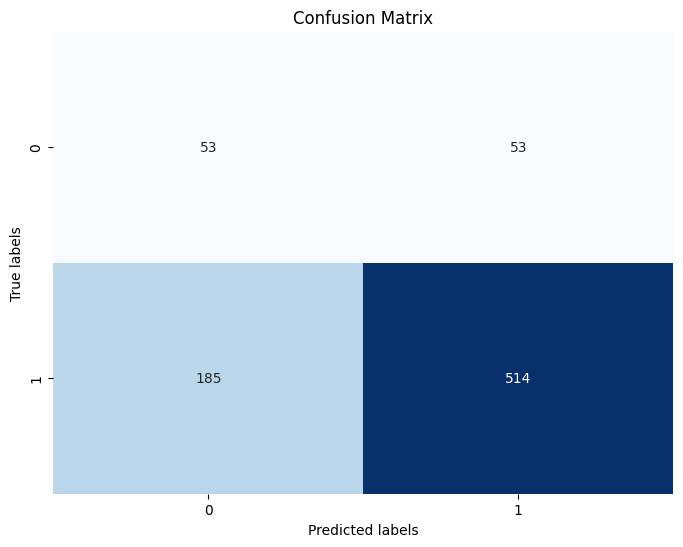

In [112]:
cm = metrics.confusion_matrix(y_test, test_predict_y)
#confusion matrix for most accurate model
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',  cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')

was ist mir wichtiger? 0,0 true, predicted oder 1,0 true, predicted. Das macht weighted aus